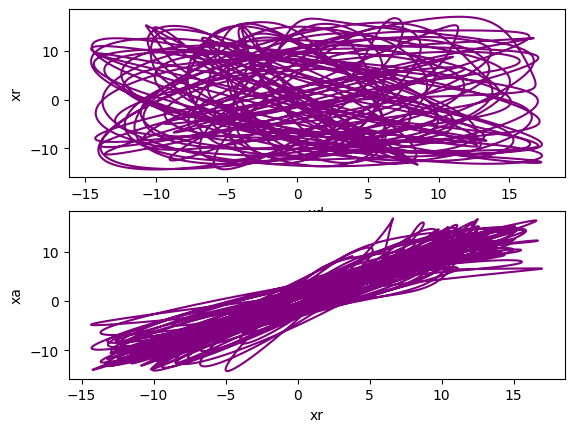

In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

a = 0.15;
p = 0.2;
c = 10.0;
wr = 0.95;
wd = 0.99;
e = 0.03;

def rossler(H, t=0):
    return np.array([(-wd*H[1])-H[2], #xd 0
                    (wd*H[0])+(a*H[1]), #yd 1
                    p+(H[2]*(H[0]-c)), #zd 2 
                    ((-wr*H[4])-H[5])+e*(H[0]-H[3]), #xr 3
                    (wr*H[3])+(a*H[4]), #yr 4 
                    p+(H[5]*(H[3]-c)), #zr 5
                    (((-wr*H[7])-H[8])+e*(H[0]-H[6])), #xa 6
                    ((wr*H[6])+(a*H[7])), #ya 7 
                    p+(H[8]*(H[6]-c))]) #za 8 
                    

T = 1000000; T0 = 400000;
t = np.linspace(0, 500, T)
#t = np.linspace(0, T/2, T)
#t = np.arange(0.1, 10000, 0.01)
#T0 = 920000


#H0 = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.1, 0.1, 0.1]
H0 = [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.05, 1.05, 1.05 ]
#H0 = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001,]
H, infodict = integrate.odeint(rossler, H0, t, full_output=True)

fig, axs = plt.subplots(2)
axs[0].plot(H[T0:,0],H[T0:,3],c='purple') #xd xr
axs[1].plot(H[T0:,3],H[T0:,6],c='purple') #xr,xa
#axs[2].plot(t,H[:,0],c='purple')

#plt.plot(H[:,3],H[:,6],c='purple') #xr,xa
#plt.plot(H[1000:,0],H[1000:,3],c='purple')
plt.setp(axs[0], xlabel='xd')
plt.setp(axs[0], ylabel='xr')
plt.setp(axs[1], xlabel='xr')
plt.setp(axs[1], ylabel='xa')
#plt.setp(axs[2], xlabel='t')
#plt.setp(axs[2], ylabel='xd')
plt.show()
#v = np.array(np.meshgrid(H[T0:,0], H[T0:,3])).T.reshape(-1, 2)
#v = np.array(np.meshgrid(H[T0:,3], t[T0:])).T.reshape(-1, 2)
#print(t[T0:])
#np.savetxt('xt.csv', v, delimiter=",")

#print(len(H[T0:,0]))







In [2]:
q = np.vstack((H[T0:,6],t[T0:])).T
df = pd.DataFrame(q, columns = ['x','t'])

df1 = pd.DataFrame(H[T0:,6])
print(df)
print(df1)

               x         t
0       9.107095  200.0002
1       9.101580  200.0007
2       9.096064  200.0012
3       9.090547  200.0017
4       9.085028  200.0022
...          ...       ...
599995 -1.412371  499.9980
599996 -1.407737  499.9985
599997 -1.403102  499.9990
599998 -1.398466  499.9995
599999 -1.393830  500.0000

[600000 rows x 2 columns]
               0
0       9.107095
1       9.101580
2       9.096064
3       9.090547
4       9.085028
...          ...
599995 -1.412371
599996 -1.407737
599997 -1.403102
599998 -1.398466
599999 -1.393830

[600000 rows x 1 columns]


<Axes: xlabel='t', ylabel='x'>

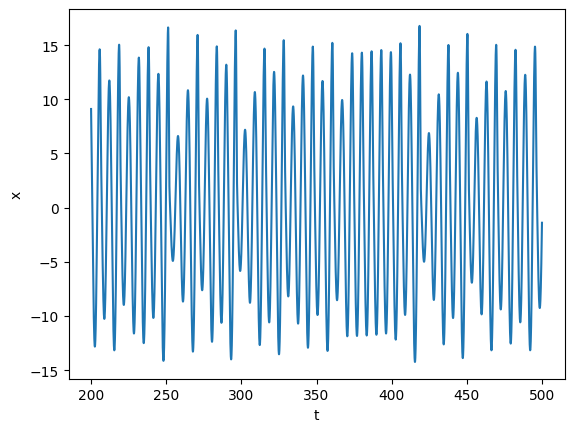

In [3]:
sns.lineplot(x='t', y='x', data=df)

<Axes: >

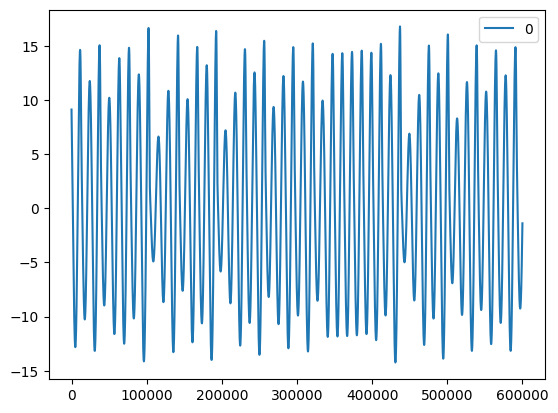

In [4]:
df1.plot()

In [5]:
t1 = t[T0:]
print(t1)

[200.0002 200.0007 200.0012 ... 499.999  499.9995 500.    ]


In [6]:
def df_to_X_y(df,t, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row=[a for a in df_as_np[i:i+5]]
    X.append(row)
    label=df_as_np[i+5]
    y.append(label)
  return np.array(X),np.array(y)

In [7]:
WINDOW_SIZE = 5
X,y = df_to_X_y(df1,t1,WINDOW_SIZE)
X.shape, y.shape

((599995, 5, 1), (599995, 1))

In [8]:
y=y.flatten()

In [9]:
X_train, y_train = X[:500000], y[:500000]
X_val, y_val = X[500000:550000], y[500000:550000]
X_test, y_test = X[550000:], y[550000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((500000, 5, 1), (500000,), (50000, 5, 1), (50000,), (49995, 5, 1), (49995,))

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [11]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [12]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp1])

Epoch 1/10
15621/15625 [============================>.] - ETA: 0s - loss: 1.6296 - root_mean_squared_error: 1.2766

15625/15625 [==============================] - 71s 4ms/step - loss: 1.6292 - root_mean_squared_error: 1.2764 - val_loss: 1.6982e-04 - val_root_mean_squared_error: 0.0130
Epoch 2/10
15616/15625 [============================>.] - ETA: 0s - loss: 1.4139e-04 - root_mean_squared_error: 0.0119

15625/15625 [==============================] - 69s 4ms/step - loss: 1.4137e-04 - root_mean_squared_error: 0.0119 - val_loss: 1.1357e-04 - val_root_mean_squared_error: 0.0107
Epoch 3/10
15624/15625 [============================>.] - ETA: 0s - loss: 1.1719e-04 - root_mean_squared_error: 0.0108

15625/15625 [==============================] - 71s 5ms/step - loss: 1.1719e-04 - root_mean_squared_error: 0.0108 - val_loss: 7.5330e-05 - val_root_mean_squared_error: 0.0087
Epoch 4/10
15618/15625 [============================>.] - ETA: 0s - loss: 9.8214e-05 - root_mean_squared_error: 0.0099

15625/15625 [==============================] - 71s 5ms/step - loss: 9.8214e-05 - root_mean_squared_error: 0.0099 - val_loss: 7.0727e-05 - val_root_mean_squared_error: 0.0084
Epoch 5/10
15622/15625 [============================>.] - ETA: 0s - loss: 8.4368e-05 - root_mean_squared_error: 0.0092

15625/15625 [==============================] - 69s 4ms/step - loss: 8.4366e-05 - root_mean_squared_error: 0.0092 - val_loss: 6.1574e-05 - val_root_mean_squared_error: 0.0078
Epoch 6/10
15623/15625 [============================>.] - ETA: 0s - loss: 7.2593e-05 - root_mean_squared_error: 0.0085

15625/15625 [==============================] - 74s 5ms/step - loss: 7.2589e-05 - root_mean_squared_error: 0.0085 - val_loss: 4.3067e-05 - val_root_mean_squared_error: 0.0066
Epoch 7/10
15625/15625 [==============================] - 75s 5ms/step - loss: 6.2487e-05 - root_mean_squared_error: 0.0079 - val_loss: 4.5389e-05 - val_root_mean_squared_error: 0.0067
Epoch 8/10
15625/15625 [==============================] - 73s 5ms/step - loss: 5.1843e-05 - root_mean_squared_error: 0.0072 - val_loss: 1.0553e-04 - val_root_mean_squared_error: 0.0103
Epoch 9/10
15625/15625 [==============================] - 72s 5ms/step - loss: 4.7085e-05 - root_mean_squared_error: 0.0069 - val_loss: 1.1636e-04 - val_root_mean_squared_error: 0.0108
Epoch 10/10
15625/15625 [==============================] - 69s 4ms/step - loss: 3.9986e-05 - root_mean_squared_error: 0.0063 - val_loss: 8.0699e-05 - val_root_mean_squared_error: 0.0090


In [13]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [14]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

15625/15625 [==============================] - 36s 2ms/step


,Train Predictions,Actuals
0,9.089381,9.079508
1,9.083849,9.073986
2,9.078317,9.068463
3,9.072781,9.062939
4,9.067245,9.057413
...,...,...
499995,14.303151,14.303180
499996,14.307103,14.307117
499997,14.311053,14.311051
499998,14.314997,14.314981


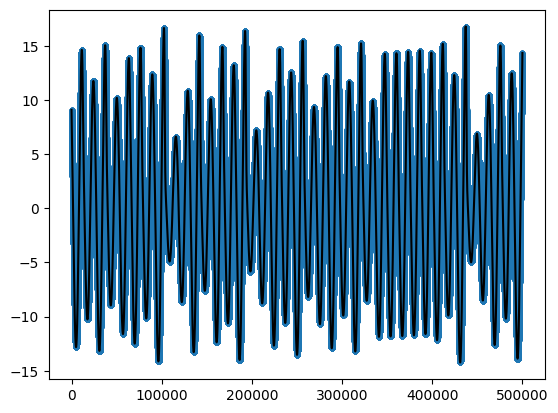

In [15]:
plt.plot(train_results['Train Predictions'],'.')
plt.plot(train_results['Actuals'],c='black')

In [16]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
val_results

1563/1563 [==============================] - 4s 2ms/step


,Val Predictions,Actuals
0,14.322875,14.322831
1,14.326808,14.326751
2,14.330738,14.330667
3,14.334667,14.334580
4,14.338590,14.338490
...,...,...
49995,7.424430,7.431559
49996,7.428033,7.435158
49997,7.431635,7.438755
49998,7.435235,7.442351


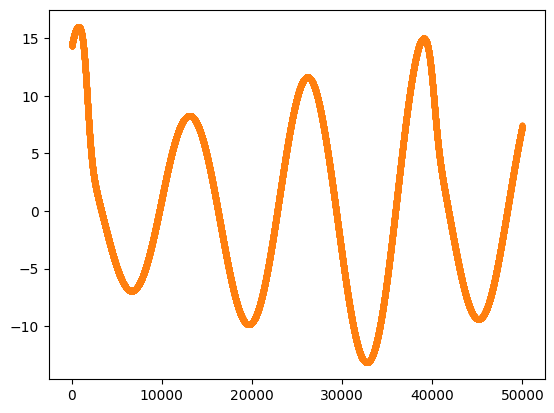

In [17]:
plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actuals'],'.')

In [18]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'test Predictions':test_predictions, 'Actuals':y_test})
test_results


1563/1563 [==============================] - 3s 2ms/step


,test Predictions,Actuals
0,7.442430,7.449538
1,7.446024,7.453129
2,7.449618,7.456719
3,7.453210,7.460307
4,7.456800,7.463894
...,...,...
49990,-1.420904,-1.412371
49991,-1.416249,-1.407737
49992,-1.411593,-1.403102
49993,-1.406937,-1.398466


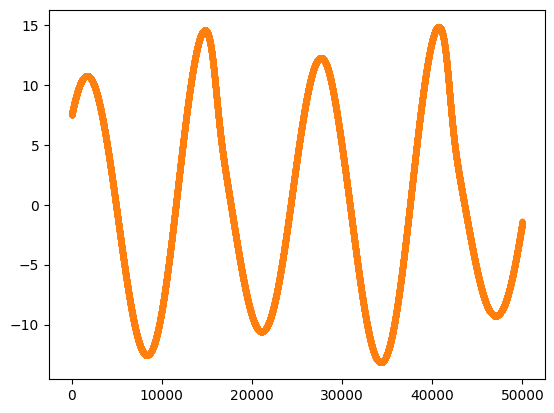

In [19]:
plt.plot(test_results['test Predictions'])
plt.plot(test_results['Actuals'],'.')

In [20]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'])
  plt.plot(df['Actuals'])
  return df, mse(y, predictions)

1563/1563 [==============================] - 4s 2ms/step


(       Predictions   Actuals
 0         7.442430  7.449538
 1         7.446024  7.453129
 2         7.449618  7.456719
 3         7.453210  7.460307
 4         7.456800  7.463894
 ...            ...       ...
 49990    -1.420904 -1.412371
 49991    -1.416249 -1.407737
 49992    -1.411593 -1.403102
 49993    -1.406937 -1.398466
 49994    -1.402280 -1.393830
 
 [49995 rows x 2 columns],
 4.541488145762488e-05)

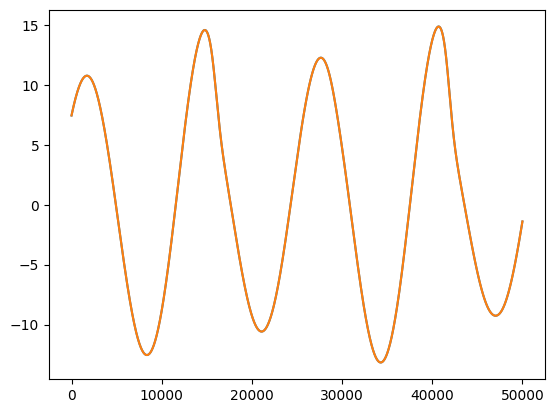

In [21]:
plot_predictions1(model1, X_test, y_test)

In [22]:
pred = model1.predict(X_test)
pred = pd.DataFrame(pred)
pred.to_csv(f"test_out2.csv",index=False,header=None)

1563/1563 [==============================] - 3s 2ms/step


In [23]:
pred1 = model1.predict(X_train)
pred1 = pd.DataFrame(pred1)
pred1.to_csv(f"xa_003.csv",index=False,header=None)

15625/15625 [==============================] - 34s 2ms/step


In [24]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 KB 17.6 MB/s eta 0:00:00


In [25]:
import tensorflow_addons as tfa
metric = tfa.metrics.r_square.RSquare()
metric.update_state(y_train, train_predictions)
result = metric.result()
result.numpy()

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


0.99999934